# SMOTEENN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [ ]:
# Load dataset
file_path = "merged_dataset_newvar.csv"
df = pd.read_csv(file_path)

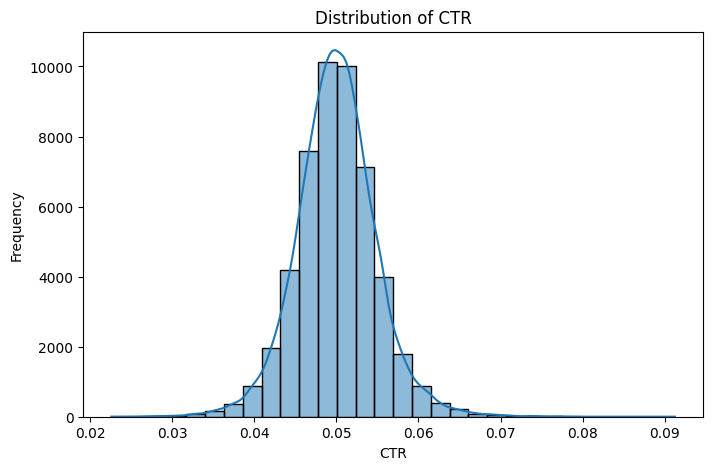

In [ ]:
# Visualisasi distribusi CTR
plt.figure(figsize=(8, 5))
sns.histplot(df["CTR"], bins=30, kde=True)
plt.xlabel("CTR")
plt.ylabel("Frequency")
plt.title("Distribution of CTR")
plt.show()

In [ ]:
# Menentukan batas kuartil
q1 = df["CTR"].quantile(0.25)
q2 = df["CTR"].quantile(0.50)
q3 = df["CTR"].quantile(0.75)

# Transformasi kolom CTR menjadi 2 kategori: Low dan High
df["CTR_Category"] = df["CTR"].apply(lambda x: "Low" if x < q2 else "High")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CTR                     50000 non-null  float64
 1   Device_Type             50000 non-null  object 
 2   Age                     50000 non-null  int64  
 3   Gender                  50000 non-null  object 
 4   Location                50000 non-null  object 
 5   Subscription_Type       50000 non-null  object 
 6   Platform                50000 non-null  object 
 7   Ad_Type                 50000 non-null  object 
 8   Product_Type            50000 non-null  object 
 9   Sentiment_Score         50000 non-null  float64
 10  Target_Audience         50000 non-null  object 
 11  Click_on_Ad             50000 non-null  int64  
 12  Time_Spent_on_Platform  50000 non-null  float64
 13  Bounce_Rate             50000 non-null  float64
 14  Ad_Relevance_Score      50000 non-null

In [ ]:
# Fitur kategorikal yang perlu encoding
categorical_features = ["Gender", "Location", "Platform",
                        "Ad_Type", "Product_Type", "Target_Audience"]

# Menggunakan Label Encoding untuk fitur kategorikal
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Simpan encoder untuk keperluan nanti

In [ ]:
# Pilih fitur dan target
X = df.drop(columns=["CTR", "CTR_Category", "Bounce_Rate", "Device_Type",
                     "Click_on_Ad", "Time_Spent_on_Platform", "Subscription_Type",
                     "Ad_Relevance_Score"])
y = df["CTR_Category"]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              50000 non-null  int64  
 1   Gender           50000 non-null  int64  
 2   Location         50000 non-null  int64  
 3   Platform         50000 non-null  int64  
 4   Ad_Type          50000 non-null  int64  
 5   Product_Type     50000 non-null  int64  
 6   Sentiment_Score  50000 non-null  float64
 7   Target_Audience  50000 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 3.1 MB


In [ ]:
y.value_counts()

,count
CTR_Category,
High,25001
Low,24999


In [ ]:
# Encode label target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
from imblearn.combine import SMOTEENN

In [ ]:
# Oversampling dengan SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smoteenn.fit_resample(X, y_encoded)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled_smoteenn, y_resampled_smoteenn, test_size=0.2, random_state=42, stratify=y_resampled_smoteenn)

In [ ]:
X_train.head()

,Age,Gender,Location,Platform,Ad_Type,Product_Type,Sentiment_Score,Target_Audience
687,57,0,0,1,0,1,0.16,0
3142,27,1,2,1,0,1,0.16,0
1714,37,1,3,1,1,0,0.90,0
4524,30,1,0,1,0,1,0.61,2
7279,32,0,3,0,2,2,0.29,1


In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Mencoba model lain - XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:16:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Prediksi dengan XGBoost
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# Evaluasi XGBoost
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_)

print(f"XGBoost Accuracy: {test_accuracy_xgb:.4f}")
print("XGBoost Classification Report:\n", report_xgb)

XGBoost Accuracy: 0.8055
XGBoost Classification Report:
               precision    recall  f1-score   support

        High       0.80      0.81      0.81       977
         Low       0.81      0.80      0.80       977

    accuracy                           0.81      1954
   macro avg       0.81      0.81      0.81      1954
weighted avg       0.81      0.81      0.81      1954



In [ ]:
import joblib  # Untuk menyimpan model


# Simpan Label Encoders
joblib.dump(label_encoders, "label_encoders.pkl")

# Simpan Label Encoder untuk Target
joblib.dump(label_encoder, "label_encoder_target.pkl")

# Simpan model XGBoost
joblib.dump(xgb_model, "xgboost_ctr_model.pkl")

['xgboost_ctr_model.pkl']

In [ ]:
import pandas as pd
import joblib
import numpy as np

# Load model dan encoder
xgb_model = joblib.load("xgboost_ctr_model.pkl")
label_encoder = joblib.load("label_encoders.pkl")
label_encoder_target = joblib.load("label_encoder_target.pkl")

# Pastikan urutan fitur sesuai dengan model
feature_columns = ['Age', 'Gender', 'Location', 'Platform',
                   'Ad_Type', 'Product_Type', 'Sentiment_Score', 'Target_Audience']

# categorical feature
categorical_features = ["Gender", "Location", "Platform",
                        "Ad_Type", "Product_Type", "Target_Audience"]

In [ ]:
# Fungsi untuk melakukan prediksi pada input baru dan menampilkan presisinya
def predict_ctr_with_confidence(input_data):
    """
    Memprediksi kategori CTR (Low/High) dan menampilkan confidence score berdasarkan input data baru.

    Parameter:
        input_data (dict): Data baru dalam format dictionary (1 sampel) atau DataFrame (banyak sampel).

    Return:
        tuple: (prediksi kategori CTR, confidence score)
    """
    # Konversi ke DataFrame jika input berupa dictionary
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])  # Convert dict ke DataFrame
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data
    else:
        raise ValueError("Input harus berupa dictionary atau DataFrame!")

    # Cek apakah semua fitur ada dalam input
    missing_cols = [col for col in feature_columns if col not in input_df.columns]
    if missing_cols:
        raise ValueError(f"Kolom berikut tidak ditemukan dalam input data: {missing_cols}")

    # Encoding fitur kategorikal
    for col in categorical_features:
        if col in input_df:
            le = label_encoder.get(col)
            if le:
                input_df[col] = le.transform(input_df[col])  # Transformasi dengan encoder lama
            else:
                raise ValueError(f"Tidak ada encoder untuk fitur {col}. Pastikan encoder telah disimpan!")

    # Pastikan urutan kolom sesuai dengan model
    input_df = input_df[feature_columns]

    # Lakukan prediksi
    y_pred_encoded = xgb_model.predict(input_df)
    y_pred_proba = xgb_model.predict_proba(input_df)  # Mengambil probabilitas

    # Konversi hasil prediksi ke label asli
    y_pred_label = label_encoder_target.inverse_transform(y_pred_encoded)

    # Ambil confidence score dari probabilitas kelas yang dipilih
    confidence_scores = np.max(y_pred_proba, axis=1)

    return y_pred_label[0], confidence_scores[0]  # Kembalikan prediksi & presisinya

In [ ]:
# Contoh data baru untuk diuji
new_data = {
    "Age": 25,
    "Gender": "Male",
    "Location": "Jakarta",
    "Platform": "Meta Ads",
    "Ad_Type": "Carousel",
    "Product_Type": "Learning Plan",
    "Sentiment_Score": 0.8,
    "Target_Audience": "Intermediate"
}

# Cetak hasil prediksi beserta confidence score
try:
    result, confidence = predict_ctr_with_confidence(new_data)
    print("Predicted CTR Category:", result)
    print("Confidence Score:", round(confidence * 100, 2), "%")  # Ditampilkan dalam persen
except Exception as e:
    print("Error:", e)

Predicted CTR Category: High
Confidence Score: 66.69 %
